In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import itertools

#### 数据预处理

In [2]:
def load_data():
    d = sio.loadmat('../data/ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

def add_bias(X):
    bias = np.ones((X.shape[0], 1))
    return np.hstack((X, bias))

#### 线性回归

In [3]:
def mse_loss_regularized(theta, X, y, lambda_reg):
    theta = theta.reshape(-1, 1)
    predictions = np.dot(X, theta)
    regularization_loss = (lambda_reg / (2 * len(y))) * np.sum(theta[:-1] ** 2)
    mse_loss = np.mean((predictions - y) ** 2) / 2
    return mse_loss + regularization_loss

def compute_gradient_regularized(theta, X, y, lambda_reg):
    m = len(y)
    n = X.shape[1]
    theta = theta.reshape(-1, 1)
    predictions = np.dot(X, theta)
    gradients = np.dot(X.transpose(), (predictions - y)) / m
    regularization_term = (lambda_reg / m) * np.concatenate((theta[:-1].flatten(), [0]))
    regularization_term = regularization_term.reshape((n, -1))
    gradients[:-1] += regularization_term[:-1]
    return gradients.flatten()

def fit(X, y, lambda_reg=0.1):
    initial_theta = np.zeros(X.shape[1])
    result = minimize(fun=mse_loss_regularized,
                      x0=initial_theta,
                      args=(X, y, lambda_reg),
                      jac=lambda theta, X, y, lambda_reg: compute_gradient_regularized(theta, X, y, lambda_reg),
                      method='BFGS')
    return result.x

#### 加载数据

In [4]:
X, y, Xval, yval, Xtest, ytest = load_data()

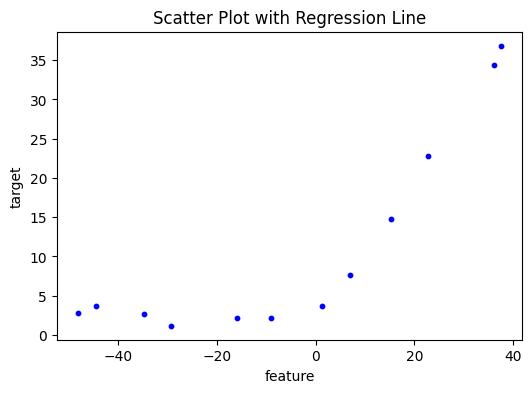

In [5]:
plt.figure(figsize=(6, 4))
plt.scatter(X, y, color='blue', s=10)
plt.xlabel('feature')
plt.ylabel('target')
plt.title('Scatter Plot with Regression Line')
plt.show()

#### 单变量线性回归

In [6]:
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)
X_with_bias = add_bias(X)

Xval = Xval.reshape(-1, 1)
yval = yval.reshape(-1, 1)
Xval_with_bias = add_bias(Xval)

Xtest = Xtest.reshape(-1, 1)
ytest = ytest.reshape(-1, 1)

In [7]:
final_theta = fit(X_with_bias, y, 0)
print(f"final_theta: {final_theta}")

final_theta: [ 0.36777923 13.08790351]


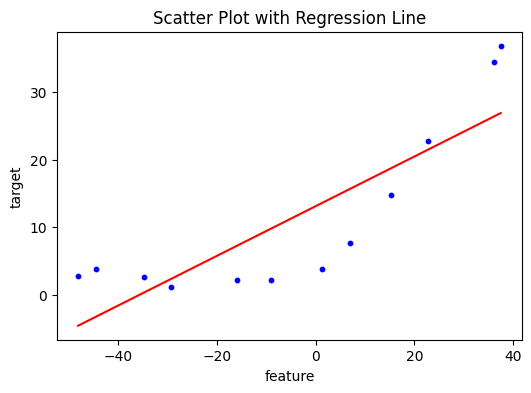

In [8]:
slope = final_theta[0]
intercept = final_theta[1]
line_x = np.linspace(X.min(), X.max(), 100)
line_y = slope * line_x + intercept

plt.figure(figsize=(6, 4))
plt.scatter(X, y, color='blue', s=10)
plt.plot(line_x, line_y, color='red')
plt.xlabel('feature')
plt.ylabel('target')
plt.title('Scatter Plot with Regression Line')
plt.show()

1.使用训练集的子集来拟合应模型

2.在计算训练代价和交叉验证代价时，没有用正则化

3.记住使用相同的训练集子集来计算训练代价

In [9]:
m = len(X)
training_cost = []
cv_cost = []

for i in range(1, m+1):
    final_theta = fit(X_with_bias[:i, :], y[:i, :])

    training_cost.append(mse_loss_regularized(final_theta, X_with_bias[:i, :], y[:i, :], 0))
    cv_cost.append(mse_loss_regularized(final_theta, Xval_with_bias, yval, 0))

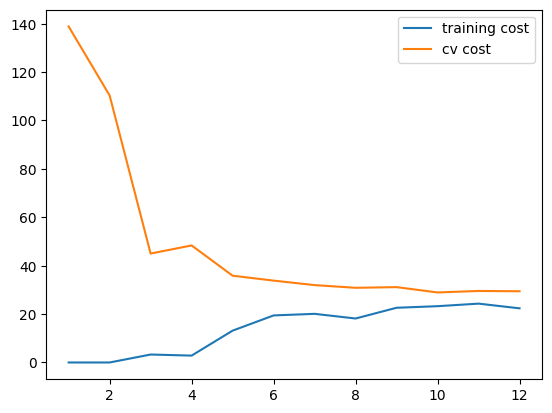

In [10]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

#### 构建多项式特征拟合数据

In [11]:
def polynomial_feature_map(X, max_degree=8):
    n_samples, n_features = X.shape
    features = []
    for degree in range(1, max_degree + 1):
        for items in itertools.combinations_with_replacement(range(n_features), degree):
            features.append(np.prod(X[:, items], axis=1))
    features.append(np.ones(n_samples))
    return np.column_stack(features)

def standardize(X):
    n_features = X.shape[1]
    standardized_X = np.ones_like(X)
    for i in range(n_features - 1):
        column = X[:, i]
        mean = column.mean()
        std = column.std()
        standardized_X[:, i] = (column - mean) / std
    return standardized_X

In [12]:
X_poly = polynomial_feature_map(X)
Xval_poly = polynomial_feature_map(Xval)
Xtest_poly = polynomial_feature_map(Xtest)

X_norm_poly = standardize(X_poly)
Xval_norm_poly = standardize(Xval_poly)
Xtest_norm_poly = standardize(Xtest_poly)

#### 画出学习曲线

In [13]:
def plot_learning_curve(X, y, Xval, yval, lambda_reg=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        optim_theta = fit(X[:i, :], y[:i], lambda_reg)

        tc = mse_loss_regularized(optim_theta, X[:i, :], y[:i], lambda_reg)
        cv = mse_loss_regularized(optim_theta, Xval, yval, lambda_reg)

        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)

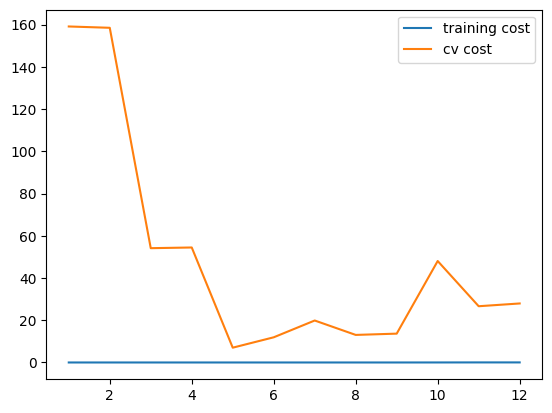

In [14]:
plot_learning_curve(X_norm_poly, y, Xval_norm_poly, yval, lambda_reg=0)
plt.show()

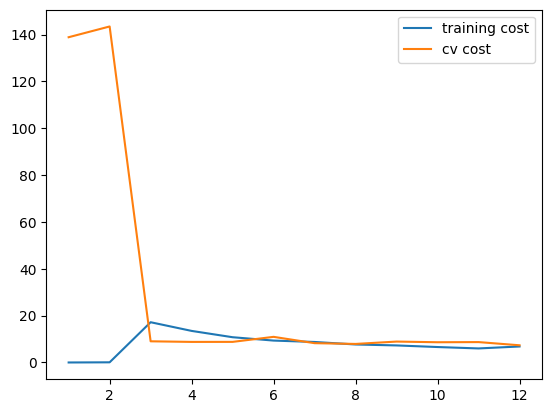

In [15]:
plot_learning_curve(X_norm_poly, y, Xval_norm_poly, yval, lambda_reg=1)
plt.show()

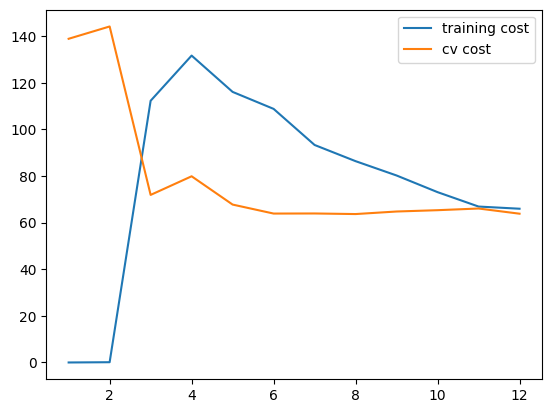

In [16]:
plot_learning_curve(X_norm_poly, y, Xval_norm_poly, yval, lambda_reg=100)
plt.show()

#### 找到最佳的正则化参数

In [17]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [18]:
for l in l_candidate:
    optim_theta = fit(X_norm_poly, y, l)
    tc = mse_loss_regularized(optim_theta, X_norm_poly, y, l)
    cv = mse_loss_regularized(optim_theta, Xval_norm_poly, yval, l)
    
    training_cost.append(tc)
    cv_cost.append(cv)

In [19]:
l_candidate[np.argmin(cv_cost)]

0.3

In [20]:
for l in l_candidate:
    theta = fit(X_norm_poly, y, l)
    print('test cost(l={}) = {}'.format(l, mse_loss_regularized(theta, Xtest_norm_poly, ytest, l)))

test cost(l=0) = 10.348237739732996
test cost(l=0.001) = 11.094589045226842
test cost(l=0.003) = 11.34695621330695
test cost(l=0.01) = 11.075274278348923
test cost(l=0.03) = 10.425499530987043
test cost(l=0.1) = 9.480867796771243
test cost(l=0.3) = 8.91626356332834
test cost(l=1) = 10.635450500681223
test cost(l=3) = 17.72034164597604
test cost(l=10) = 36.63827430873737
